In [1]:
pwd

'/mmfs1/data/aglinska/BC-MRI-AE/misc/jacobian_pca'

In [2]:
import numpy as np 
import pandas as pd
import ants

from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt

In [3]:
df = pd.read_csv('../../Data/ABIDE_legend_S982.csv')
patients = df['DxGroup'].values==1
df_asd = df.iloc[patients]

In [4]:
subs = df_asd['BIDS_ID'].values

In [5]:
fn_temp = '../../../jacobians/normed_Js_masked/{}_normed_Js_masked.nii'

In [6]:
ims = [ants.image_read(fn_temp.format(sub)) for sub in tqdm(subs)]

100%|██████████| 470/470 [00:03<00:00, 135.45it/s]


In [7]:
flatmap = np.array([im.numpy().flatten() for im in ims]) 
flatmap = flatmap[:,((flatmap**2).sum(axis=0)!=0)] # only analyze voxels with values > 0
flatmap = flatmap-flatmap.mean(axis=0) # center each voxel at zero
#flatmap = flatmap-flatmap.mean(axis=1)[:,np.newaxis] # center each subject at zero
flatmap.shape

(470, 55432)

In [8]:
from sklearn.decomposition import PCA
j_pca = PCA().fit_transform(flatmap) # PCA across voxels

In [9]:
jacobians_flat = np.array([im.numpy().flatten() for im in ims])

In [18]:
from scipy.stats import pearsonr
corr = pearsonr

In [22]:
v = 55500
corr(jacobians_flat[:,v],j_pca[:,0])

(-0.1357427822119267, 0.0031915867045599977)

In [29]:
res = np.array([corr(jacobians_flat[:,v],j_pca[:,0]) for v in tqdm(range(jacobians_flat.shape[1]))])
xcorr_r = res[:,0]
xcorr_p = res[:,1]

100%|██████████| 262144/262144 [00:05<00:00, 49648.00it/s]


In [37]:
res = np.array([corr(jacobians_flat[:,v],j_pca[:,1]) for v in tqdm(range(jacobians_flat.shape[1]))])
ycorr_r = res[:,0]
ycorr_p = res[:,1]

100%|██████████| 262144/262144 [00:05<00:00, 49866.17it/s]


In [38]:
# Runtime warning when correlating zero voxels, can ignore
#xcorr = np.array([np.corrcoef(jacobians_flat[:,v],j_pca[:,0])[0,1] for v in tqdm(range(jacobians_flat.shape[1]))])
#ycorr = np.array([np.corrcoef(jacobians_flat[:,v],j_pca[:,1])[0,1] for v in tqdm(range(jacobians_flat.shape[1]))])

In [84]:
xcorr_r_threshed = xcorr_r.copy()
ycorr_r_threshed = ycorr_r.copy()

p_thresh = .05/(~np.isnan(xcorr_p)).sum()

xcorr_r_threshed[xcorr_p>p_thresh]=np.nan
ycorr_r_threshed[ycorr_p>p_thresh]=np.nan

In [85]:
temp = ants.image_read('single_subj_T1.nii')
temp = temp.resample_image(resample_params=(64,64,64), use_voxels=True, interp_type=1)

In [86]:
xcorr_nii = ims[0].new_image_like(xcorr_r_threshed.reshape((64,64,64))) #.plot_ortho(flat=True,black_bg=True,cmap='bwr')
ycorr_nii = ims[0].new_image_like(ycorr_r_threshed.reshape((64,64,64))) #.plot_ortho(flat=True,black_bg=True,cmap='bwr')

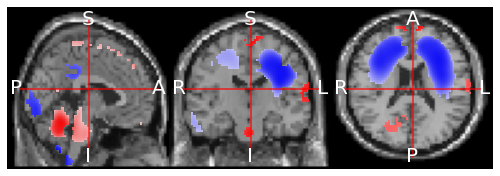

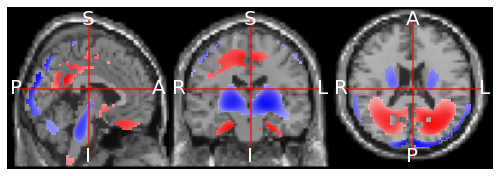

In [87]:
temp.plot_ortho(xcorr_nii,flat=True,black_bg=True,cmap='gray',overlay_cmap='bwr')
temp.plot_ortho(ycorr_nii,flat=True,black_bg=True,cmap='gray',overlay_cmap='bwr')

In [93]:
ycorr_r_threshed[np.isnan(ycorr_r_threshed)]=0
xcorr_r_threshed[np.isnan(xcorr_r_threshed)]=0

ims[0].new_image_like(xcorr_r_threshed.reshape((64,64,64))).to_filename('xcorr-bonf.nii')
ims[0].new_image_like(ycorr_r_threshed.reshape((64,64,64))).to_filename('ycorr-bonf.nii')

In [67]:
print(np.nanmin(xcorr).round(3),np.nanmean(xcorr).round(3),np.nanmax(xcorr).round(3))
print(np.nanmin(ycorr).round(3),np.nanmean(ycorr).round(3),np.nanmax(ycorr).round(3))

-0.694 -0.069 0.781
-0.665 0.003 0.774


array([nan, nan, nan, ..., nan, nan, nan])